In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import optim

print('torch.cuda.is_available():', torch.cuda.is_available())
print('torch.cuda.device_count():', torch.cuda.device_count())

torch.cuda.is_available(): True
torch.cuda.device_count(): 1


In [3]:
import random
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import utils
import models
import fl_utils as fl

In [4]:
# Set a seed value
seed = 42 
os.environ['PYTHONHASHSEED']=str(seed)
torch.manual_seed(0)
random.seed(seed)
np.random.seed(seed)

In [5]:
save_interval = 10
save_dir = './output/federated_multi_class'
os.makedirs(save_dir, exist_ok=True)

In [6]:
batch_size = 32
num_workers = 2

data_dir = './data/'
train_dir = os.path.join(data_dir, 'client_data')
valid_dir = os.path.join(data_dir, 'valid_sub')

# For testing the global model.
transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor()])
valid_data = ImageFolder(valid_dir, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_classes = len(valid_data.classes)

In [7]:
# To create custom dataset.
label_idx_dict = dict()
for idx, key in enumerate(sorted(valid_data.classes)):
    label_idx_dict[key] = idx
label_idx_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___healthy': 2,
 'Corn___Common_rust': 3,
 'Corn___Northern_Leaf_Blight': 4,
 'Corn___healthy': 5,
 'Grape___Black_rot': 6,
 'Grape___Esca_(Black_Measles)': 7,
 'Grape___healthy': 8,
 'Tomato___Early_blight': 9,
 'Tomato___Septoria_leaf_spot': 10,
 'Tomato___healthy': 11}

In [8]:
# To remap labels to class names.
idx_label_dict = dict((value, key) for key, value in label_idx_dict.items())
# idx_label_dict

In [9]:
client_list = sorted(os.listdir(train_dir))
print(client_list)

['client_0', 'client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7']


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes)
glob_model.to(device)
glob_w = glob_model.state_dict()

In [11]:
num_rounds = 400
num_local_epochs = 3
num_workers = 2

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
_, performance_log = utils.get_performance_loggers(metric_keys)

for round_no in range(num_rounds):
    utils.print_separator(text='Round: {}'.format(round_no))
    client_updates = dict()
    
    # Federated training.
    for client in client_list:
        print('client:', client)
        client_data_dir = os.path.join(train_dir, client)
        client_dataset = fl.MultiClassClientData(client_data_dir, label_idx_dict, transform=transform)
        client_data_loader = torch.utils.data.DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        client_update = fl.local_update(models.CNNModel(num_classes).to(device), glob_w, client_data_loader, num_local_epochs)
        for key in ['local_w', 'num_samples', 'loss', 'acc']:
            client_updates.setdefault(key, list()).append(client_update[key])
            
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Average training performance.
    performance_log['train_loss'].append(sum(client_updates['loss'])/len(client_updates['loss']))
    performance_log['train_acc'].append(sum(client_updates['acc'])/len(client_updates['acc']))
    
    # Validate the global model.
    valid_loss, valid_acc = fl.evaluate_model(glob_model, valid_loader)
    performance_log['valid_loss'].append(valid_loss)
    performance_log['valid_acc'].append(valid_acc)
    
    utils.print_result(performance_log)
    
    if  (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'round_{}_loss_{:.2f}_acc_{:.2f}.pth'.format(round_no+1, performance_log['valid_loss'][-1], performance_log['valid_acc'][-1])))
    
utils.save_pickle(os.path.join(save_dir, 'performance_log.pickle'), performance_log)


 ==================== Round: 0 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0929          acc:    0.3626
valid     -              loss :    2.4848          acc:    0.0716


 ==================== Round: 1 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0555          acc:    0.4188
valid     -              loss :    2.4815          acc:    0.1007


 ==================== Round: 2 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0454          acc:    0.3976
valid     -              loss :    2.4663          acc:    0.1177


 ==================== Round: 3

client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1424          acc:    0.9499
valid     -              loss :    1.8051          acc:    0.3775


 ==================== Round: 26 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1192          acc:    0.9587
valid     -              loss :    1.7642          acc:    0.3917


 ==================== Round: 27 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1256          acc:    0.9570
valid     -              loss :    1.7294          acc:    0.4019


 ==================== Round: 28 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: cli

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0448          acc:    0.9885
valid     -              loss :    1.8213          acc:    0.3895


 ==================== Round: 52 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0378          acc:    0.9888
valid     -              loss :    1.4446          acc:    0.5396


 ==================== Round: 53 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0183          acc:    0.9946
valid     -              loss :    1.8356          acc:    0.3895


 ==================== Round: 54 ====================

client: client_0
client: client_1
client: cli

client: client_7
train     -              loss :    0.0278          acc:    0.9897
valid     -              loss :    1.2681          acc:    0.6257


 ==================== Round: 77 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1464          acc:    0.9861
valid     -              loss :    1.6316          acc:    0.6148


 ==================== Round: 78 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0168          acc:    0.9938
valid     -              loss :    1.3931          acc:    0.6199


 ==================== Round: 79 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1057          acc:    0.9865
valid     -              loss :    1.6222          acc:    0.6363


 ==================== Round: 103 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0326          acc:    0.9944
valid     -              loss :    1.7063          acc:    0.6221


 ==================== Round: 104 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0934          acc:    0.9759
valid     -              loss :    1.3924          acc:    0.6675


 ==================== Round: 105 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.2972          acc:    0.9770
valid     -              loss :    2.0910          acc:    0.6272


 ==================== Round: 128 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0494          acc:    0.9879
valid     -              loss :    1.6708          acc:    0.6377


 ==================== Round: 129 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0304          acc:    0.9927
valid     -              loss :    1.6966          acc:    0.6359


 ==================== Round: 130 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0412          acc:    0.9928
valid     -              loss :    2.3862          acc:    0.6206


 ==================== Round: 154 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.4311          acc:    0.9770
valid     -              loss :    2.0546          acc:    0.6595


 ==================== Round: 155 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1463          acc:    0.9708
valid     -              loss :    1.7826          acc:    0.5607


 ==================== Round: 156 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.1988          acc:    0.9772
valid     -              loss :    2.1393          acc:    0.6010


 ==================== Round: 179 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.5235          acc:    0.9756
valid     -              loss :    2.2235          acc:    0.6675


 ==================== Round: 180 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.0657          acc:    0.9883
valid     -              loss :    2.5799          acc:    0.5516


 ==================== Round: 181 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.5823          acc:    0.9646
valid     -              loss :    2.5012          acc:    0.6159


 ==================== Round: 205 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.3913          acc:    0.9629
valid     -              loss :    2.3458          acc:    0.6461


 ==================== Round: 206 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.8936          acc:    0.9534
valid     -              loss :    2.8131          acc:    0.6537


 ==================== Round: 207 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.1238          acc:    0.9793
valid     -              loss :    2.6352          acc:    0.5912


 ==================== Round: 230 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1111          acc:    0.9795
valid     -              loss :    2.2921          acc:    0.6014


 ==================== Round: 231 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1493          acc:    0.9824
valid     -              loss :    2.9608          acc:    0.6650


 ==================== Round: 232 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    2.0957          acc:    0.9702
valid     -              loss :    3.6756          acc:    0.6126


 ==================== Round: 256 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1299          acc:    0.9764
valid     -              loss :    3.8435          acc:    0.5890


 ==================== Round: 257 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.1287          acc:    0.9904
valid     -              loss :    3.7988          acc:    0.6770


 ==================== Round: 258 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.2558          acc:    0.9759
valid     -              loss :    4.3917          acc:    0.5963


 ==================== Round: 281 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.3299          acc:    0.9349
valid     -              loss :    2.6773          acc:    0.5552


 ==================== Round: 282 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.4822          acc:    0.9710
valid     -              loss :    3.1254          acc:    0.5908


 ==================== Round: 283 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    3.1001          acc:    0.9747
valid     -              loss :    5.6558          acc:    0.6355


 ==================== Round: 307 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.2040          acc:    0.9698
valid     -              loss :    5.5423          acc:    0.5887


 ==================== Round: 308 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.3303          acc:    0.9695
valid     -              loss :    5.5522          acc:    0.5007


 ==================== Round: 309 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    0.7538          acc:    0.9496
valid     -              loss :    5.0749          acc:    0.6014


 ==================== Round: 332 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    4.1057          acc:    0.9554
valid     -              loss :    8.5281          acc:    0.5690


 ==================== Round: 333 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.7710          acc:    0.9561
valid     -              loss :    7.7041          acc:    0.6795


 ==================== Round: 334 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.4385          acc:    0.9727
valid     -              loss :    3.8907          acc:    0.5015


 ==================== Round: 358 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.0531          acc:    0.9810
valid     -              loss :    5.5745          acc:    0.6497


 ==================== Round: 359 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.4755          acc:    0.9532
valid     -              loss :    4.6376          acc:    0.5214


 ==================== Round: 360 ====================

client: client_0
client: client_1
client: 

client: client_5
client: client_6
client: client_7
train     -              loss :    6.4030          acc:    0.9575
valid     -              loss :    7.0605          acc:    0.5487


 ==================== Round: 383 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    1.4391          acc:    0.9657
valid     -              loss :    6.2905          acc:    0.6599


 ==================== Round: 384 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: client_6
client: client_7
train     -              loss :    0.4463          acc:    0.9887
valid     -              loss :    6.8852          acc:    0.6715


 ==================== Round: 385 ====================

client: client_0
client: client_1
client: client_2
client: client_3
client: client_4
client: client_5
client: 

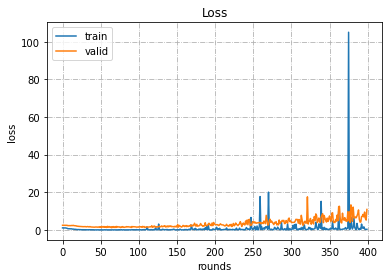

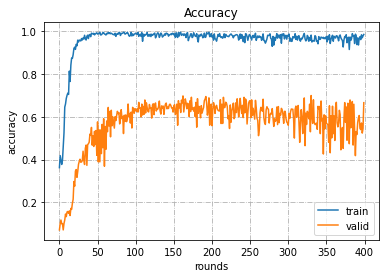

In [12]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
utils.save_history_plot(performance_log, loss_plot_config)

acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['save_dir'] = os.path.join(save_dir, 'accuracy.png')
acc_plot_config['show_img'] = True
utils.save_history_plot(performance_log, acc_plot_config)

In [11]:
# Reload model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes=num_classes)
glob_model.to(device)
glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'round_300_loss_4.70_acc_0.57.pth')))

performance_log = utils.load_pickle(os.path.join(save_dir, 'performance_log.pickle'))

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
performance_dict, _ = utils.get_performance_loggers(metric_keys)

criterion = nn.CrossEntropyLoss()
# Validation.
glob_model.eval()
with torch.no_grad():
    for step, data in enumerate(tqdm(valid_loader)):
        x_batch, y_batch = data[0].to(device), data[1].to(device)
        _, y_pred = glob_model(x_batch)
        loss = criterion(y_pred, y_batch)
        performance_dict['valid_loss'].update_state(loss.item())
        performance_dict['valid_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
    
    print('valid_loss:', performance_dict['valid_loss'].result())
    print('valid_acc:', performance_dict['valid_acc'].result())

100%|███████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.81it/s]

valid_loss: 4.698989053857609
valid_acc: 0.5708575581395349


In [14]:
t_list = [100, 200, 300]
for t in t_list:
    print('{:.2f}'.format(performance_log['valid_acc'][t-1]))

0.64
0.66
0.57


In [15]:
performance_log['valid_acc'][290:300]

[0.6082848837209303,
 0.6395348837209303,
 0.6326308139534884,
 0.6126453488372093,
 0.5697674418604651,
 0.6253633720930233,
 0.6253633720930233,
 0.5926598837209303,
 0.5759447674418605,
 0.5708575581395349]

In [16]:
utils.get_mean_std(performance_log['valid_acc'][290:300])

mean:0.61
std:0.03


In [15]:
dataiter = iter(valid_loader)

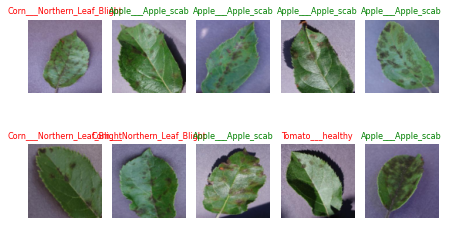

In [18]:
with torch.no_grad():
    data = dataiter.next()
    x_batch, y_batch = data[0].to(device), data[1].to(device)
    _, y_pred = glob_model(x_batch)
    _, predicted = torch.max(y_pred, 1)
    
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(x_batch[i]))
    txt_color = 'green' if (predicted[i] == y_batch[i]) else 'red'
    plt.title(valid_data.classes[predicted[i]], color=txt_color, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# client = client_list[0]
# client = 'client_8'
# client_data_dir = os.path.join(train_dir, client)
# client_dataset = fl.MultiClassClientData(client_data_dir, label_idx_dict, transform=transform)
# client_data_loader = torch.utils.data.DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# def imshow(img):
#     npimg = img.numpy()
#     plt.axis('off')
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# dataiter = iter(client_data_loader)
# images, labels = dataiter.next()

# imshow(torchvision.utils.make_grid(images[:4]))
# print([idx_label_dict[label.item()] for label in labels[:4]])